# Latent Dirichlet Allocation GridSearchCV Part 2: Fine Search

While the score is better at `n_components = 12`, and is likely even better closer to `n_components = 15`, `n_components = 10` and `learning_decay = 0.85` (or greater) seem reasonable.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.latex.repr=True

file_path = '../input/'

load_data_dtype = {'order_id': np.uint32,
                   'user_id': np.uint32,
                   'eval_set': 'category',
                   'order_number': np.uint8,
                   'order_dow': np.uint8,
                   'order_hour_of_day': np.uint8,
                   # pandas 'gotcha'; leave as float:
                   'days_since_prior_order': np.float16,
                   'product_id': np.uint16,
                   'add_to_cart_order': np.uint8,
                   'reordered': np.bool
                   }

df_aisles = pd.read_csv(file_path + 'aisles.csv')
df_departments = pd.read_csv(file_path + 'departments.csv')
df_products = pd.read_csv(file_path + 'products.csv')

# Specify dtype to reduce memory utilization
df_order_products_prior = pd.read_csv(file_path + 'order_products__prior.csv',
                                      dtype=load_data_dtype
                                      )
df_order_products_train = pd.read_csv(file_path + 'order_products__train.csv',
                                      dtype=load_data_dtype
                                      )
df_orders = pd.read_csv(file_path + 'orders.csv',
                        dtype=load_data_dtype
                        )

# df_prior = full products from all prior orders 
df_prior = pd.merge(df_orders[df_orders['eval_set'] == 'prior'],
              df_order_products_prior,
              on='order_id'
              )

In [2]:
from sklearn.model_selection import train_test_split

# Names of dataset partitions
dsets = ['train',
         'test',
         'kaggle']

users = dict.fromkeys(dsets)

# Use sklearn utility to partition project users into train and test user lists.
users['train'], users['test'] = train_test_split(list(df_orders[df_orders.eval_set == 'train']['user_id']),
                                                 test_size=0.2,
                                           random_state=20190513)

# Kaggle submissions test set
users['kaggle'] = list(df_orders[df_orders.eval_set == 'test']['user_id'])#.to_list()

In [3]:
# Split DataFrames we will use in feature construction into dicts of DataFrames
prior = dict.fromkeys(dsets)
orders = dict.fromkeys(dsets)

for ds in dsets:
    prior[ds] = df_prior[df_prior['user_id'].isin(users[ds])]
    orders[ds] = df_orders[df_orders['user_id'].isin(users[ds]) & (df_orders.eval_set == 'prior')]

In [4]:
# scipy sparse matrix of number of times particular user has ordered particular product
UP_orders_num = dict.fromkeys(dsets)

for ds in dsets:
    UP_orders_num[ds], _, _ = (prior[ds].groupby(['user_id', 'product_id'])['order_id']
                             .count()
                             .apply(pd.to_numeric, downcast='unsigned')
                             .to_sparse()
                             .to_coo())

In [5]:
del (df_aisles,
     df_departments,
     df_order_products_prior,
     df_order_products_train,
     df_orders,
     df_prior,
     df_products,
     prior,
     orders)

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_jobs=1, # need more disk? PickleError
                                  learning_method='online'
                               )

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_components': [6, 8, 10, 12], # Maybe we can get away with fewer n_components (memory)
    'learning_decay': [0.75, 0.80, 0.85]
}

lda_search = GridSearchCV(lda,
                          param_grid=params,
                          cv=3,
                          return_train_score=False)

lda_search.fit(UP_orders_num['train'])

results = pd.DataFrame(lda_search.cv_results_)

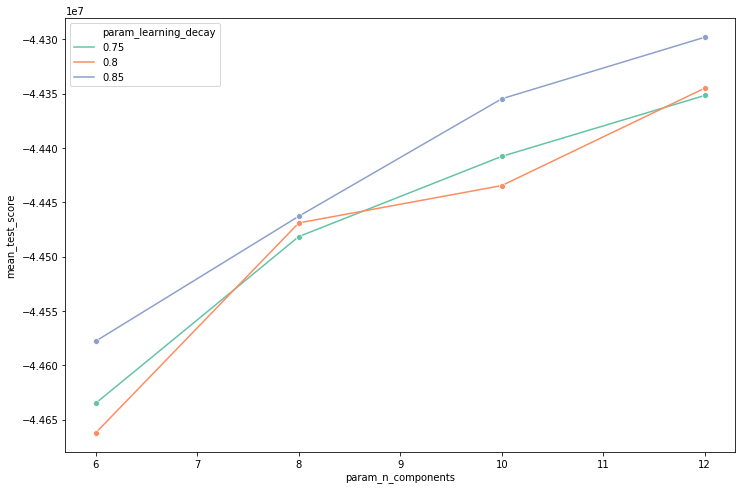

In [8]:
current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             # https://github.com/mwaskom/seaborn/issues/1515
             palette=current_palette,
             marker='o'
            )

# # Would need a good way to show three error bars
# plt.errorbar(x=results['param_n_components'],
#              y=results.mean_test_score,
#              yerr=results.std_test_score,
#              fmt='none',
#              color=current_palette[0])

plt.show()

In [9]:
# Values for the above plot
results[['param_learning_decay',
         'param_n_components',
         'mean_test_score']].pivot('param_learning_decay',
                                  'param_n_components')

mean_test_score      ...                   
param_n_components                6       ...                 12
param_learning_decay                      ...                   
0.75                   -4.463476e+07      ...      -4.435172e+07
0.80                   -4.466195e+07      ...      -4.434502e+07
0.85                   -4.457765e+07      ...      -4.429817e+07

[3 rows x 4 columns]

In [10]:
# std for the values in the above plot
results[['param_learning_decay',
         'param_n_components',
         'std_test_score']].pivot('param_learning_decay',
                                  'param_n_components')

std_test_score      ...                     
param_n_components               6       ...                   12
param_learning_decay                     ...                     
0.75                  216817.367738      ...        228169.482819
0.80                  269358.882712      ...        210123.253409
0.85                  156826.207775      ...        148142.774307

[3 rows x 4 columns]